In [1]:
import warnings
warnings.filterwarnings('ignore')
import datetime
import os
import gc
from collections import namedtuple
from pprint import pprint
from tqdm import tqdm

import numpy as np
import pandas as pd

import tensorboard
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR, CyclicLR
import torchmetrics

from datasets import load_dataset, load_from_disk, concatenate_datasets, DatasetDict, Dataset
from transformers import get_linear_schedule_with_warmup
from transformers import DataCollatorForSeq2Seq
from transformers import BartConfig, T5Config
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
import evaluate
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from test_utils import generate_seq, generate_input_target, generate_from_data, eval

2023-05-12 01:56:38.087301: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 01:56:39.330766: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/wsl/lib:
2023-05-12 01:56:39.330864: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/wsl/lib:
2023-05-12 01:56:39.330871: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

In [2]:
checkpoint = '230510-16_32'
tokenized_dataset_path = './data/gogamza-kobart-base-v2_tokenized_dataset'
baseline_checkpoint_path = f'/home/thesol1/projects/KoGrammar/models/{checkpoint}'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
if os.path.exists(tokenized_dataset_path):
    tokenized_dataset = load_from_disk(tokenized_dataset_path)
    print(tokenized_dataset)
else:
    print("Tokenized dataset not found")

DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1016426
    })
    train_baseline: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 508213
    })
    train_distil: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 508212
    })
    valid: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 56468
    })
    test: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 56469
    })
})


## Baseline Test

In [5]:
tokenizer = AutoTokenizer.from_pretrained(baseline_checkpoint_path)
model = AutoModelForSeq2SeqLM.from_pretrained(baseline_checkpoint_path).to(device)
model.eval()

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(30000, 768, padding_idx=3)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(30000, 768, padding_idx=3)
      (embed_positions): BartLearnedPositionalEmbedding(1028, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=

In [6]:
validset = tokenized_dataset['valid'].shuffle()
test_sample = validset.shuffle().select(range(1))
test_sample

Dataset({
    features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1
})

In [7]:
validset = tokenized_dataset['valid'].with_format("torch", device=device)
test_sample = validset.shuffle().select(range(1))
print(test_sample['input_ids'].shape)
output = generate_from_data(model, tokenizer, test_sample)

print(output['input_text'], output['generated_text'], output['target_text'], sep='\n\n')

torch.Size([1, 512])
헉 닭칼국수 지나가면서 가게만 몇 번 봤어요..!

헉, 닭칼국수 지나가면서 가게만 몇 번 봤어요!

헉, 닭칼국수 지나가면서 가게만 몇 번 봤어요!


In [8]:
type(validset)

datasets.arrow_dataset.Dataset

In [9]:
accuracy_lt = []
bleu_score_lt = []
rouge_score_lt = []
accuracy = evaluate.load('accuracy')
bleu = evaluate.load('google_bleu')
#rouge = evaluate.load('rouge')
rouge = Rouge()

for example in tqdm(validset.shuffle().select(range(2000))):
    data = dict()
    for key in example:
        data[key] = example[key].unsqueeze(0)
    output = generate_from_data(model, tokenizer, data)
    generated_text = output['generated_text']
    target_text = output['target_text']

    try:
        #accuracy_score = accuracy.compute(predictions=generated_text, references=target_text, tokenizer=tokenizer)
        #bleu_score = bleu.compute(predictions=generated_text, references=target_text, tokenizer=tokenizer)
        bleu_score = sentence_bleu([target_text], generated_text, smoothing_function=SmoothingFunction().method1)
        rouge_score = rouge.get_scores(generated_text, target_text)[0]['rouge-2']['f']
        #rouge_score = rouge.compute(predictions=generated_text, references=target_text)
    except ValueError:
        continue

    #accuracy_lt.append(accuracy_score)
    bleu_score_lt.append(bleu_score)
    rouge_score_lt.append(rouge_score)

bleu_score_series = pd.Series(bleu_score_lt)
rouge_score_series = pd.Series(rouge_score_lt)
print(bleu_score_series.mean(), rouge_score_series.mean(), sep='\t')
result_df = pd.concat([bleu_score_series, rouge_score_series], axis=1)

100%|██████████| 2000/2000 [07:09<00:00,  4.66it/s]

0.8047882442441403	0.5687885504984175


In [10]:
result_df.columns = ['BLEU-2', 'ROUGE-2 F1']
result_df.to_csv(f'./result-data/{checkpoint}-valid_result.csv')
result_df.describe()

,BLEU-2,ROUGE-2 F1
count,1953.000000,1953.000000
mean,0.804788,0.568789
std,0.254530,0.435386
min,0.000000,0.000000
25%,0.690065,0.000000
50%,0.912168,0.666667
75%,1.000000,1.000000
max,1.000000,1.000000


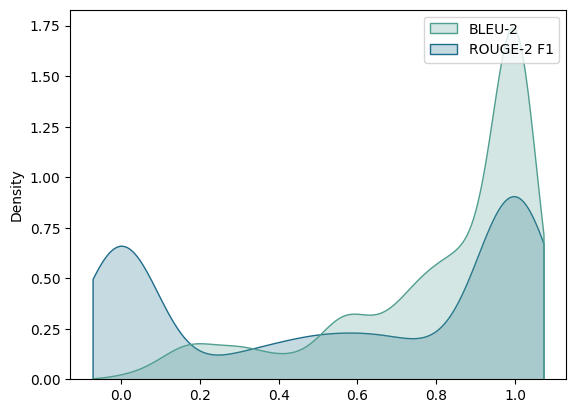

In [15]:
ax = sns.kdeplot(data=result_df, fill=True, palette="crest", common_grid=True, cut=1)